<a href="https://colab.research.google.com/github/pnvijay/walk_with_fastai/blob/main/03_Cross_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's find out the GPU that we have got

In [1]:
!nvidia-smi

Sun Nov 22 12:26:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Let's import fastai

In [2]:
!pip install fastai -q --upgrade
import fastai
fastai.__version__

'2.1.5'

We know the version of fastai above. It keeps changing so better to be cognizant of this

The aim of this notebook is to understand Cross Validation. Let's begin with importing the Imagewoof dataset

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.IMAGEWOOF)
path.ls()

(#2) [Path('/root/.fastai/data/imagewoof2/val'),Path('/root/.fastai/data/imagewoof2/train')]

As we can see above, the dataset has training and test data subsets. Now let us define the batch transforms and item transforms that we can define on the data as it goes through the GPU

In [4]:
batch_tfms = [IntToFloatTensor(),*aug_transforms(size=224, max_warp=0),Normalize.from_stats(*imagenet_stats)]
item_tfms = [ToTensor(),RandomResizedCrop(size=460,min_scale=0.75,ratio=(1.,1.))]
bs=64

Now we will use index splitting to split the train data subset into train and valid data sub sets

In [5]:
IndexSplitter??

In [6]:
train_imgs = get_image_files(path/'train')
test_imgs = get_image_files(path/'val')
len(train_imgs),len(test_imgs)

(9025, 3929)

We know the length or count of images in train and test sub sets. Let us know split the train subset into train and valid data sub set

For that let's use a 80-20 split ratio. We will also randomly shuffle the train images. 

In [7]:
random.shuffle(train_imgs)
## The below code provides the 80% split index value
start_val = len(train_imgs) - int(len(train_imgs)*0.2)
## we now create a range of indexes starting from 80% of train images index to its full length
idxs = range(start_val,len(train_imgs))

We now will use the 80%-100% index range of the train images to create the split of train images. Anything from 0-80% will be in train images and anything from 81% to 100% will be in validation dataset.

In [8]:
splits = IndexSplitter(idxs)
split = splits(train_imgs)
split

((#7220) [0,1,2,3,4,5,6,7,8,9...],
 (#1805) [7220,7221,7222,7223,7224,7225,7226,7227,7228,7229...])

We now have the split of train images and valid images. We will use these values and add to that the index values of the test images so that we now have the index values for all three - train , valid and test.

In [9]:
split_list = [split[0],split[1]]
split_list.append(L(range(len(train_imgs),len(train_imgs)+len(test_imgs))))
split_list

[(#7220) [0,1,2,3,4,5,6,7,8,9...],
 (#1805) [7220,7221,7222,7223,7224,7225,7226,7227,7228,7229...],
 (#3929) [9025,9026,9027,9028,9029,9030,9031,9032,9033,9034...]]

Now that we have the splits, let's create the datasets using the data subsets given to us.

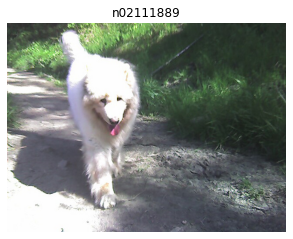

In [10]:
dsrc = Datasets(train_imgs+test_imgs,tfms = [[PILImage.create],[parent_label,Categorize]],
                                            splits=split_list)
show_at(dsrc.train,3)

As you can see above, we are also using the show_at to show the train images available at index no 3. Lets explore the datasets a bit and see what is contains.

In [11]:
dsrc

(#12954) [(PILImage mode=RGB size=309x426, TensorCategory(9)),(PILImage mode=RGB size=500x333, TensorCategory(9)),(PILImage mode=RGB size=500x375, TensorCategory(1)),(PILImage mode=RGB size=500x375, TensorCategory(8)),(PILImage mode=RGB size=638x453, TensorCategory(9)),(PILImage mode=RGB size=500x375, TensorCategory(4)),(PILImage mode=RGB size=500x332, TensorCategory(8)),(PILImage mode=RGB size=500x358, TensorCategory(5)),(PILImage mode=RGB size=334x500, TensorCategory(7)),(PILImage mode=RGB size=434x600, TensorCategory(9))...]

In [12]:
dsrc.n_subsets

3

In [13]:
len(dsrc.train),len(dsrc.valid)

(7220, 1805)

In [14]:
dsrc.subset(2)

(#3929) [(PILImage mode=RGB size=500x375, TensorCategory(0)),(PILImage mode=RGB size=500x375, TensorCategory(0)),(PILImage mode=RGB size=500x375, TensorCategory(0)),(PILImage mode=RGB size=220x210, TensorCategory(0)),(PILImage mode=RGB size=792x528, TensorCategory(0)),(PILImage mode=RGB size=500x375, TensorCategory(0)),(PILImage mode=RGB size=500x375, TensorCategory(0)),(PILImage mode=RGB size=500x375, TensorCategory(0)),(PILImage mode=RGB size=500x375, TensorCategory(0)),(PILImage mode=RGB size=375x500, TensorCategory(0))...]

In [15]:
dsrc.subset(0)

(#7220) [(PILImage mode=RGB size=309x426, TensorCategory(9)),(PILImage mode=RGB size=500x333, TensorCategory(9)),(PILImage mode=RGB size=500x375, TensorCategory(1)),(PILImage mode=RGB size=500x375, TensorCategory(8)),(PILImage mode=RGB size=638x453, TensorCategory(9)),(PILImage mode=RGB size=500x375, TensorCategory(4)),(PILImage mode=RGB size=500x332, TensorCategory(8)),(PILImage mode=RGB size=500x358, TensorCategory(5)),(PILImage mode=RGB size=334x500, TensorCategory(7)),(PILImage mode=RGB size=434x600, TensorCategory(9))...]

In [16]:
dsrc.subset(1)

(#1805) [(PILImage mode=RGB size=500x375, TensorCategory(0)),(PILImage mode=RGB size=582x625, TensorCategory(3)),(PILImage mode=RGB size=383x500, TensorCategory(0)),(PILImage mode=RGB size=310x233, TensorCategory(3)),(PILImage mode=RGB size=298x298, TensorCategory(7)),(PILImage mode=RGB size=550x370, TensorCategory(7)),(PILImage mode=RGB size=188x150, TensorCategory(3)),(PILImage mode=RGB size=300x224, TensorCategory(7)),(PILImage mode=RGB size=500x375, TensorCategory(9)),(PILImage mode=RGB size=500x343, TensorCategory(8))...]

Let's now create a dataloader from the dataset. we will here use the item_tfms and batch_tfms

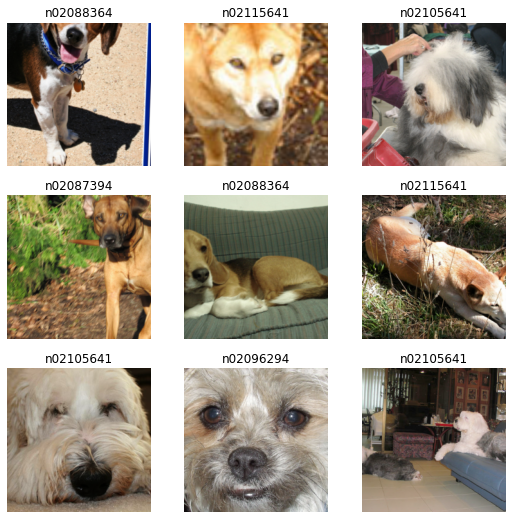

In [17]:
dls = dsrc.dataloaders(bs=bs,after_item=item_tfms,after_batch=batch_tfms)
dls.show_batch()

Let's now use a pretrained model and train the model on this dataset and dataloaders. We will use resnet34

In [18]:
dls.n_subsets

3

In [19]:
learn = cnn_learner(dls,resnet34,pretrained=True,metrics=accuracy).to_fp16()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.496712,0.203967,0.944598,01:22


In [20]:
learn.validate(ds_idx=2)

(#2) [0.2135126143693924,0.9358615279197693]

Now lets do K-Fold Cross Validation

In [21]:
from sklearn.model_selection import StratifiedKFold

Lets create a collection of train_labels

In [23]:
train_labels = L()
for i in range(len(dsrc.train)):
  train_labels.append(dsrc.train[i][1])
for i in range(len(dsrc.valid)):
  train_labels.append(dsrc.valid[i][1])
train_labels

(#9025) [TensorCategory(9),TensorCategory(9),TensorCategory(1),TensorCategory(8),TensorCategory(9),TensorCategory(4),TensorCategory(8),TensorCategory(5),TensorCategory(7),TensorCategory(9)...]

Let's create the KFolds

In [24]:
kf = StratifiedKFold(n_splits=10,shuffle=True)

Let's also randomly shuffle the train images

In [25]:
import random
random.shuffle(train_imgs)

In [30]:
val_pct = []
tst_preds = []
for _,val_idx in kf.split(np.array(train_imgs),train_labels):
  splits = IndexSplitter(val_idx)
  split= splits(train_imgs)
  split_list = [split[0],split[1]]
  split_list.append(L(range(len(train_imgs),len(train_imgs)+len(test_imgs))))
  dsrc = Datasets(train_imgs+test_imgs,tfms=[[PILImage.create],[parent_label,Categorize]],splits=split_list)
  dls = dsrc.dataloaders(bs=64,after_item=item_tfms,after_batch=batch_tfms)
  learn = cnn_learner(dls,resnet34,pretrained=True,metrics=accuracy).to_fp16()
  learn.fit_one_cycle(1)
  val_pct.append(learn.validate()[1])
  a,b = learn.get_preds(ds_idx=2)
  tst_preds.append(a)

epoch,train_loss,valid_loss,accuracy,time
0,0.457043,0.149590,0.952381,01:22


epoch,train_loss,valid_loss,accuracy,time
0,0.434026,0.173490,0.935770,01:23


epoch,train_loss,valid_loss,accuracy,time
0,0.432784,0.174635,0.942414,01:23


epoch,train_loss,valid_loss,accuracy,time
0,0.440966,0.144009,0.946844,01:25


epoch,train_loss,valid_loss,accuracy,time
0,0.434820,0.225034,0.916944,01:24


epoch,train_loss,valid_loss,accuracy,time
0,0.453096,0.207340,0.932373,01:25


epoch,train_loss,valid_loss,accuracy,time
0,0.434097,0.189498,0.939024,01:24


epoch,train_loss,valid_loss,accuracy,time
0,0.442412,0.178165,0.941242,01:24


epoch,train_loss,valid_loss,accuracy,time
0,0.466318,0.226326,0.930155,01:24


epoch,train_loss,valid_loss,accuracy,time
0,0.441834,0.177337,0.943459,01:24


Now let's try to average

In [31]:
tst_preds_copy = tst_preds.copy()

Let's try and see how the predictions by the model which has used the train and validation datasets in the first fold of the stratified kfold to train itself, fares in terms of accuracy against the known targets in the test data set.

In [32]:
accuracy(tst_preds_copy[0],b)

TensorImage(0.9392)

Taking this further lets find the accuracy of the model trained using each fold against the known targets

In [34]:
for i in range(len(tst_preds_copy)):
  print(accuracy(tst_preds_copy[i],b))

TensorImage(0.9392)
TensorImage(0.9382)
TensorImage(0.9410)
TensorImage(0.9394)
TensorImage(0.9351)
TensorImage(0.9407)
TensorImage(0.9407)
TensorImage(0.9379)
TensorImage(0.9305)
TensorImage(0.9384)


In order to show the power of averaging let's take the values of the first fold

In [36]:
hat = tst_preds_copy[0]
hat

TensorImage([[3.1440e-01, 7.8785e-03, 6.4744e-03,  ..., 5.6708e-01, 2.1184e-03,
         1.5681e-03],
        [9.9999e-01, 6.1905e-08, 7.4672e-08,  ..., 8.8515e-07, 2.2747e-06,
         1.6662e-08],
        [7.4813e-01, 2.7189e-04, 2.7788e-02,  ..., 2.1533e-03, 1.3541e-03,
         1.1903e-03],
        ...,
        [1.5010e-07, 1.9580e-06, 9.9272e-04,  ..., 2.0924e-06, 8.5958e-07,
         4.5525e-06],
        [1.8437e-05, 2.9453e-04, 8.8102e-04,  ..., 6.8326e-06, 6.8996e-06,
         2.4410e-06],
        [3.0503e-04, 1.4081e-01, 4.2861e-02,  ..., 1.0793e-03, 1.9659e-03,
         5.4288e-02]])

In [37]:
len(hat)

3929

To that variable 'hat', we will add the predictions made by the model using the values from each fold. Then we will average that variable 'hat' and then determine the accuracy.

In [38]:
hat[0]

TensorImage([0.3144, 0.0079, 0.0065, 0.0010, 0.0373, 0.0614, 0.0007, 0.5671, 0.0021,
        0.0016])

In [39]:
for pred in tst_preds_copy[1:]:
  hat += pred
hat

TensorImage([[3.0604e+00, 3.0800e-02, 5.6301e-02,  ..., 4.3317e+00, 2.6702e-01,
         7.2217e-02],
        [9.9987e+00, 1.9246e-05, 2.9890e-05,  ..., 1.0878e-04, 1.2905e-04,
         3.8416e-06],
        [3.4927e+00, 7.1169e-02, 2.6895e-01,  ..., 3.6238e-01, 2.4714e-01,
         4.5181e-02],
        ...,
        [6.9282e-06, 1.3943e-04, 1.8231e-02,  ..., 1.0641e-04, 9.0891e-06,
         2.9770e-05],
        [2.6153e-05, 4.4915e-03, 4.7301e-03,  ..., 4.7001e-05, 2.9351e-05,
         8.3615e-06],
        [1.2555e-03, 2.7504e+00, 1.9879e-01,  ..., 4.0140e-03, 1.1156e-02,
         3.1722e-01]])

In [40]:
len(hat)

3929

In [41]:
hat[0]

TensorImage([3.0604, 0.0308, 0.0563, 0.0124, 0.7197, 1.3194, 0.1299, 4.3317, 0.2670,
        0.0722])

In [42]:
hat /= len(tst_preds_copy)

In [43]:
accuracy(hat,b)

TensorImage(0.9494)

In [44]:
hat[0]

TensorImage([0.3060, 0.0031, 0.0056, 0.0012, 0.0720, 0.1319, 0.0130, 0.4332, 0.0267,
        0.0072])

In [47]:
import numpy as np

In [48]:
np.argmax(hat[0])

TensorImage(7)